<a href="https://colab.research.google.com/github/JulioLaz/breast_cancer_nb/blob/main/Pron%C3%B3stico_cancer_de_mama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

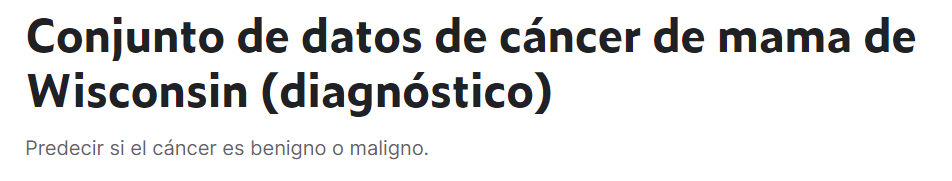

# Proyecto de Ciencia de Datos utilizando Machine Learning para diagnosticar si el tumor es maligno o benigno

# **M -> 1 = Maligno**
# **B -> 0 = Benigno**

**Dataset:** https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

Acerca del conjunto de datos
Las características se calculan a partir de una imagen digitalizada de una aspiración con aguja fina (PAAF) de una masa mamaria. Describen características de los núcleos celulares presentes en la imagen.
En el espacio tridimensional es el descrito en: [KP Bennett y OL Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

Esta base de datos también está disponible a través del servidor ftp de UW CS:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/

También se puede encontrar en el repositorio de aprendizaje automático de UCI: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Información de atributos:

1) Número de identificación
2) Diagnóstico (M = maligno, B = benigno)
3-32)

Se calculan diez características de valor real para cada núcleo celular:

a) radio (media de las distancias desde el centro a los puntos del perímetro)
b) textura (desviación estándar de los valores de la escala de grises)
c) perímetro
d) área
e) suavidad (variación local en la longitud del radio)
f) compacidad (perímetro^2 / área - 1,0)
g) concavidad (severidad de las porciones cóncavas del contorno)
h) puntos cóncavos (número de porciones cóncavas del contorno)
i) simetría
j) dimensión fractal ("aproximación de la línea costera" - 1)

Para cada imagen se calcularon la media, el error estándar y el "peor" o mayor (media de los tres valores más grandes), lo
que dio como resultado 30 características. Por ejemplo, el campo 3 es Radio medio, el campo
13 es Radio SE y el campo 23 es Peor radio.

Todos los valores de las características se recodifican con cuatro dígitos significativos.

Valores de atributos faltantes: ninguno

Distribución de clases: 357 benignos, 212 malignos

## Info del método de extracción de muestra mamaria (PAAF):

https://www.cancer.net/es/blog/2022-07/biopsia-por-aspiraci%C3%B3n-con-aguja-fina-paaf-c%C3%B3mo-prepararse-y-qu%C3%A9-esperar

# Librerias

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install ydata-profiling

In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix
import inspect
from sklearn.neural_network import MLPClassifier
# Desactivar las advertencias de convergencia
warnings.filterwarnings("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None)

# from ydata_profiling import ProfileReport


# 1. Obtención de datos:

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/Machine Learning alura/cancer/data.csv')
dataset.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [5]:
dataset.shape

(569, 33)

In [6]:
dataset.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [7]:
dataset.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [8]:
dataset.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [9]:
dataset.drop(columns=['id','Unnamed: 32'], axis=1, inplace=True)
dataset.diagnosis.replace('M', 1, inplace=True)
dataset.diagnosis.replace('B', 0, inplace=True)
dataset.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

## traducir variables:

In [11]:
# Diccionario con los nombres originales como claves y los nombres traducidos como valores
nombres_traducidos = {
    'diagnosis': 'diagnostico',
    'radius_mean': 'radio promedio',
    'texture_mean': 'textura promedio',
    'perimeter_mean': 'perimetro promedio',
    'area_mean': 'area promedio',
    'smoothness_mean': 'suavidad promedio',
    'compactness_mean': 'compacidad promedio',
    'concavity_mean': 'concavidad promedio',
    'concave points_mean': 'puntos concavos promedio',
    'symmetry_mean': 'simetria promedio',
    'fractal_dimension_mean': 'dimension fractal promedio',
    'radius_se': 'radio se',
    'texture_se': 'textura se',
    'perimeter_se': 'perimetro se',
    'area_se': 'area se',
    'smoothness_se': 'suavidad se',
    'compactness_se': 'compacidad se',
    'concavity_se': 'concavidad se',
    'concave points_se': 'puntos concavos se',
    'symmetry_se': 'simetria se',
    'fractal_dimension_se': 'dimension fractal se',
    'radius_worst': 'radio peor',
    'texture_worst': 'textura peor',
    'perimeter_worst': 'perimetro peor',
    'area_worst': 'area peor',
    'smoothness_worst': 'suavidad peor',
    'compactness_worst': 'compacidad peor',
    'concavity_worst': 'concavidad peor',
    'concave points_worst': 'puntos concavos peor',
    'symmetry_worst': 'simetria peor',
    'fractal_dimension_worst': 'dimension fractal peor'
}

# Cambiar los nombres de las columnas en el DataFrame
dataset.rename(columns=nombres_traducidos, inplace=True)


### Generar reporte HTML

In [12]:
# profile = ProfileReport(dataset)
# profile.to_file("informe.html")

### Reducir memoria

In [13]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

dataset = reduce_memory_usage(dataset, verbose=True)

Mem. usage decreased to 0.03 Mb (75.3% reduction)


In [14]:
### Convertir a int8 las columnas:
dataset['area promedio'] = dataset['area promedio'].astype('int8')
dataset['area se'] = dataset['area se'].astype('int8')
dataset['area peor'] = dataset['area peor'].astype('int8')

In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   diagnostico                 569 non-null    int8   
 1   radio promedio              569 non-null    float16
 2   textura promedio            569 non-null    float16
 3   perimetro promedio          569 non-null    float16
 4   area promedio               569 non-null    int8   
 5   suavidad promedio           569 non-null    float16
 6   compacidad promedio         569 non-null    float16
 7   concavidad promedio         569 non-null    float16
 8   puntos concavos promedio    569 non-null    float16
 9   simetria promedio           569 non-null    float16
 10  dimension fractal promedio  569 non-null    float16
 11  radio se                    569 non-null    float16
 12  textura se                  569 non-null    float16
 13  perimetro se                569 non

### Guardar dataset optimizado en Drive

In [16]:
dataset.to_csv('/content/drive/MyDrive/Machine Learning alura/cancer/data_cancer_final.csv', index=False)

In [65]:
# Obtener el número total de filas del DataFrame
total_filas = len(dataset)

# Calcular la cantidad de filas que representan la mitad del DataFrame
# mitad_filas = total_filas*2/3
mitad_filas = total_filas *2 // 3

# Seleccionar la mitad de las filas de forma aleatoria
mitad_aleatoria = dataset.sample(n=mitad_filas, random_state=42)
mitad_aleatoria.to_csv('/content/drive/MyDrive/Machine Learning alura/cancer/data_cancer_379files.csv', index=False)
mitad_aleatoria.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379 entries, 204 to 232
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   diagnostico                 379 non-null    int8   
 1   radio promedio              379 non-null    float16
 2   textura promedio            379 non-null    float16
 3   perimetro promedio          379 non-null    float16
 4   area promedio               379 non-null    int8   
 5   suavidad promedio           379 non-null    float16
 6   compacidad promedio         379 non-null    float16
 7   concavidad promedio         379 non-null    float16
 8   puntos concavos promedio    379 non-null    float16
 9   simetria promedio           379 non-null    float16
 10  dimension fractal promedio  379 non-null    float16
 11  radio se                    379 non-null    float16
 12  textura se                  379 non-null    float16
 13  perimetro se                379 n

In [17]:
describe=(dataset.drop(columns='diagnostico',axis=1).describe().loc[['max', 'min', 'mean']]).copy()
describe = reduce_memory_usage(describe, verbose=True)

Mem. usage decreased to 0.00 Mb (72.6% reduction)


In [18]:
describe
# describe.loc['mean']

,radio promedio,textura promedio,perimetro promedio,area promedio,suavidad promedio,compacidad promedio,concavidad promedio,puntos concavos promedio,simetria promedio,dimension fractal promedio,radio se,textura se,perimetro se,area se,suavidad se,compacidad se,concavidad se,puntos concavos se,simetria se,dimension fractal se,radio peor,textura peor,perimetro peor,area peor,suavidad peor,compacidad peor,concavidad peor,puntos concavos peor,simetria peor,dimension fractal peor
max,28.109375,39.281250,188.50000,127.000000,0.163452,0.345459,0.426758,0.201172,0.303955,0.097412,2.873047,4.886719,21.984375,124.000000,0.031128,0.135376,0.395996,0.052795,0.078979,0.029846,36.031250,49.531250,251.25000,127.000000,0.222656,1.057617,1.251953,0.291016,0.663574,0.207520
min,6.980469,9.710938,43.78125,-128.000000,0.052643,0.019379,0.000000,0.000000,0.106018,0.049957,0.111511,0.360107,0.756836,-128.000000,0.001713,0.002253,0.000000,0.000000,0.007881,0.000895,7.929688,12.023438,50.40625,-128.000000,0.071167,0.027283,0.000000,0.000000,0.156494,0.055054
mean,14.132812,19.296875,91.93750,-11.226562,0.096375,0.104370,0.088806,0.048920,0.181152,0.062744,0.405029,1.216797,2.867188,29.046875,0.007042,0.025482,0.031891,0.011795,0.020538,0.003796,16.265625,25.671875,107.25000,2.599609,0.132324,0.254150,0.272217,0.114563,0.290039,0.083923


In [19]:
memory_usage = dataset.memory_usage(deep=True) / 1024 ** 2
print(f'memory usage of features:\n{memory_usage.head(7)}')
print('memory usage sum:',memory_usage.sum())

memory usage of features:
Index                 0.000122
diagnostico           0.000543
radio promedio        0.001085
textura promedio      0.001085
perimetro promedio    0.001085
area promedio         0.000543
suavidad promedio     0.001085
dtype: float64
memory usage sum: 0.03159523010253906


## Dividir datos de entrenamiento/prueba y estandarizar:

In [73]:
from sklearn.preprocessing import Normalizer

X = dataset.drop(columns='diagnostico', axis=1)
y = dataset.diagnostico
scaler=StandardScaler()
scaler.fit(X)

X_std = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, random_state= 42, test_size= 0.3)
# X_train_nst, X_test_nst, y_train_nst, y_test_nst = train_test_split(X, y, random_state= 42, test_size= 0.3)

## Buscar mejore hiperparametros de MLPClasifier

In [21]:
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.neural_network import MLPClassifier

# # Definir el modelo MLPClassifier
# mlp = MLPClassifier(max_iter=200, solver='adam', learning_rate='adaptive')

# # Realizar la validación cruzada para evaluar el rendimiento del modelo
# scores = cross_val_score(mlp, X_train, y_train, cv=5)

# # Calcular el promedio de los puntajes de validación cruzada
# mean_score = scores.mean()

# # Ajustar los hiperparámetros utilizando GridSearchCV
# param_grid = {
#     'hidden_layer_sizes': [(100,), (50, 50), (50,)],
#     'alpha': [0.0001, 0.001, 0.01],
# }
# grid_search = GridSearchCV(mlp, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Obtener el mejor modelo y su puntaje
# best_model = grid_search.best_estimator_
# best_score = grid_search.best_score_

# print("Mean cross-validation score:", mean_score)
# print("Best cross-validation score after hyperparameter tuning:", best_score)
# print("Best parameters:", grid_search.best_params_)


# Mean cross-validation score: 0.9723101265822784
# Best cross-validation score after hyperparameter tuning: 0.9748417721518987
# Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (50, 50)}

## Entrenar modelos y buscar mejor Score

In [22]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(C=1, n_jobs=-1)
logistic.fit(X_train, y_train)

LogisticRegression(C=1, n_jobs=-1)

In [23]:
print(f'LogisticRegression: Score {logistic.score(X_test, y_test):.3%}')

LogisticRegression: Score 98.246%


In [24]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
print(f'RandomForestClassifier: Score {forest.score(X_test, y_test):.3%}')

RandomForestClassifier: Score 96.491%


In [26]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [27]:
print(f'SVC: Score {svm.score(X_test, y_test):.3%}')

SVC: Score 96.491%


In [28]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=200, solver='adam', learning_rate='adaptive', alpha=0.01)
mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.01, learning_rate='adaptive')

In [29]:
print(f'MLPClassifier: Score {mlp.score(X_train, y_train):.3%}')

MLPClassifier: Score 99.246%


## DataFrame: Scores de los modelos:

In [30]:
### Crear DataFrame apartir de diccionario con los puntajes de cada modelo

scores = {
    'LogisticRegression': f'{logistic.score(X_test, y_test):.3%}',
    'RandomForestClassifier': f'{forest.score(X_test, y_test):.3%}',
    'SVC': f'{svm.score(X_test, y_test):.3%}',
    'MLPClassifier': f'{mlp.score(X_test, y_test):.3%}'
}

scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Score'])
scores_df_T=(scores_df.T).copy()
styled_scores_df = scores_df_T.style.set_properties(**{'text-align': 'center'})

# Encuentra el máximo valor
max_score = scores_df_T.max().max()

# Define una función para aplicar estilos
def highlight_max(s):
    is_max = s == max_score
    return ['font-weight: bold; color: red' if v else '' for v in is_max]

# Aplica los estilos
styled_scores_df = scores_df_T.style.apply(highlight_max)

styles = [
    {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'th.col_heading', 'props': [('text-align', 'center')]}
]

# Aplica el estilo para centrar el texto
styled_scores_df = styled_scores_df.set_table_styles(styles)

styled_scores_df


,LogisticRegression,RandomForestClassifier,SVC,MLPClassifier
Score,98.246%,96.491%,96.491%,98.830%


# 2. Visualizando datos:

In [31]:
# Contar las ocurrencias de cada valor en la columna 'diagnostico'
diagnosis_counts = dataset['diagnostico'].value_counts()

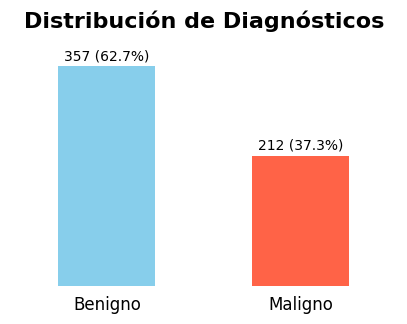

In [32]:
plt.figure(figsize=(5, 3))
bars = diagnosis_counts.plot(kind='bar', color=['#87CEEB','#FF6347'])  # Rojo para positivo y Azul para negativo
plt.title('Distribución de Diagnósticos',pad=20,fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.grid(False)
plt.box(False)
plt.xticks(range(len(diagnosis_counts)), ['Benigno', 'Maligno'], rotation=0, fontsize=12)
plt.yticks([])
plt.tick_params(axis='x', which='both', bottom=False, top=False, direction='out', width=2, colors='black')


for i in range(len(diagnosis_counts)):
    plt.text(i, diagnosis_counts[i] + 5, f'{diagnosis_counts[i]} ({diagnosis_counts[i]/sum(diagnosis_counts)*100:.1f}%)', ha='center', va='bottom')

plt.show()


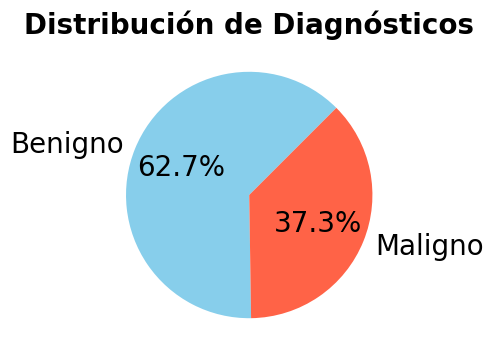

In [33]:
plt.figure(figsize=(4, 4))
plt.pie(diagnosis_counts, labels=['Benigno', 'Maligno'], colors=['#87CEEB', '#FF6347'], autopct='%1.1f%%', startangle=45, textprops={'fontsize': 20})
plt.title('Distribución de Diagnósticos',fontsize=20, fontweight='bold')
plt.show()


### Crear X1
**apartir de X_std y con la columna target excluida: 'diagnostico**

In [34]:
X1 = pd.DataFrame(X_std, columns= X.keys())

In [35]:
X1.head(2)

,radio promedio,textura promedio,perimetro promedio,area promedio,suavidad promedio,compacidad promedio,concavidad promedio,puntos concavos promedio,simetria promedio,dimension fractal promedio,radio se,textura se,perimetro se,area se,suavidad se,compacidad se,concavidad se,puntos concavos se,simetria se,dimension fractal se,radio peor,textura peor,perimetro peor,area peor,suavidad peor,compacidad peor,concavidad peor,puntos concavos peor,simetria peor,dimension fractal peor
0,1.095703,-2.072266,1.270508,-0.161621,1.569336,3.283203,2.652344,2.531250,2.218750,2.257812,2.488281,-0.565430,2.830078,-3.740234,-0.21460,1.316406,0.724609,0.660645,1.148438,0.906250,1.886719,-1.360352,2.304688,-0.436523,1.308594,2.617188,2.109375,2.294922,2.753906,1.936523
1,1.827148,-0.354736,1.684570,0.785645,-0.828613,-0.487549,-0.023697,0.548828,-0.000407,-0.868652,0.499268,-0.875977,0.263428,1.273438,-0.60498,-0.693359,-0.440674,0.259521,-0.805176,-0.099304,1.805664,-0.369873,1.534180,-1.307617,-0.376465,-0.430176,-0.146851,1.086914,-0.245361,0.282715


### Funcion para graficar: Distribución de frecuencias de diagnóstico por variable

In [36]:
def violin(inicio, fin):
  colors=['#87CEEB', '#FF6347']
  datos= pd.concat([y,X1.iloc[:,inicio:fin]], axis= 1)
  datos= pd.melt(datos, id_vars='diagnostico', var_name='examenes', value_name='resultados')
  plt.figure(figsize=(30,8))
  sns.violinplot(data= datos, x= 'examenes', y= 'resultados', hue= 'diagnostico', split=True,palette=colors,linewidth=0.6)
  plt.legend(title='Diagnóstico', prop={'size': 10})
  plt.ylabel('')
  plt.xlabel('')
  plt.title('Distribución de frecuencias de diagnóstico por variable', fontsize=16, fontweight='bold')
  plt.legend(title='Diagnóstico', prop={'size': 10},loc='best')
  plt.grid(False)
  plt.box(False)
  plt.tick_params(axis='x', which='both', bottom=False, top=False, direction='out', width=2, colors='black')
  plt.tick_params(axis='y', which='both', left=False, right=False, direction='out', width=2, colors='gray')
  plt.xticks(rotation=50)

In [37]:
def boxplot_var():
    ### Nueva plantilla:
    new_template = {'layout': {'font': {'family': 'verdana', 'size': 10, 'color': 'white'}}}
    pio.templates['new_template'] = new_template
    pio.templates['new_template']['layout']['font'] = {'family': 'verdana', 'size': 10, 'color': 'white'}

    # columnas numéricas:
    columns_numeric = X.columns.tolist()

    # plotly setup
    plot_rows=5
    plot_cols=6
    fig = make_subplots(rows=plot_rows, cols=plot_cols, shared_yaxes=False)
    # add traces
    x = 0
    for i in range(1, plot_rows + 1):
        for j in range(1, plot_cols + 1):
            fig.add_trace(go.Box(y=dataset[columns_numeric[x]].values,
                                name = dataset[columns_numeric].columns[x],
                                ),
                        row=i,
                        col=j)
            x=x+1
    fig.update_layout(
        width=1500,
        height=1200, showlegend=False)

    fig.show()

##Gráficas de distribución:

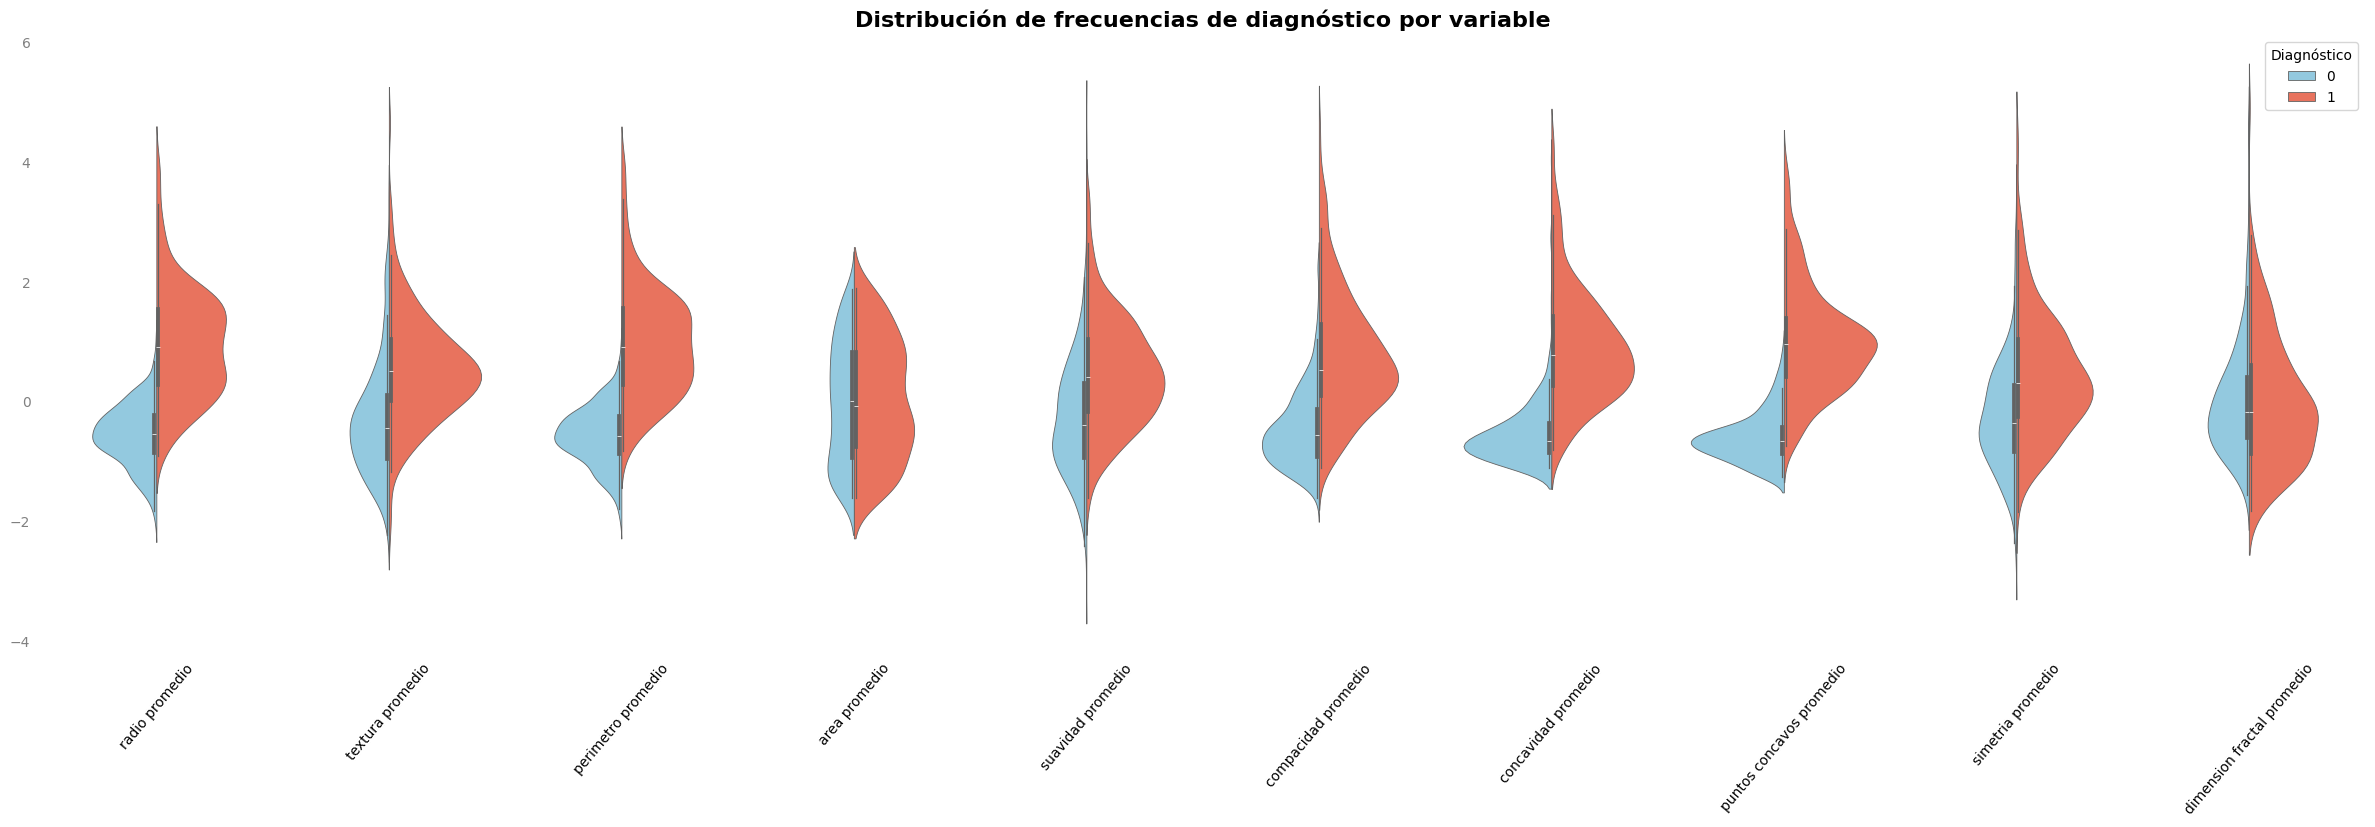

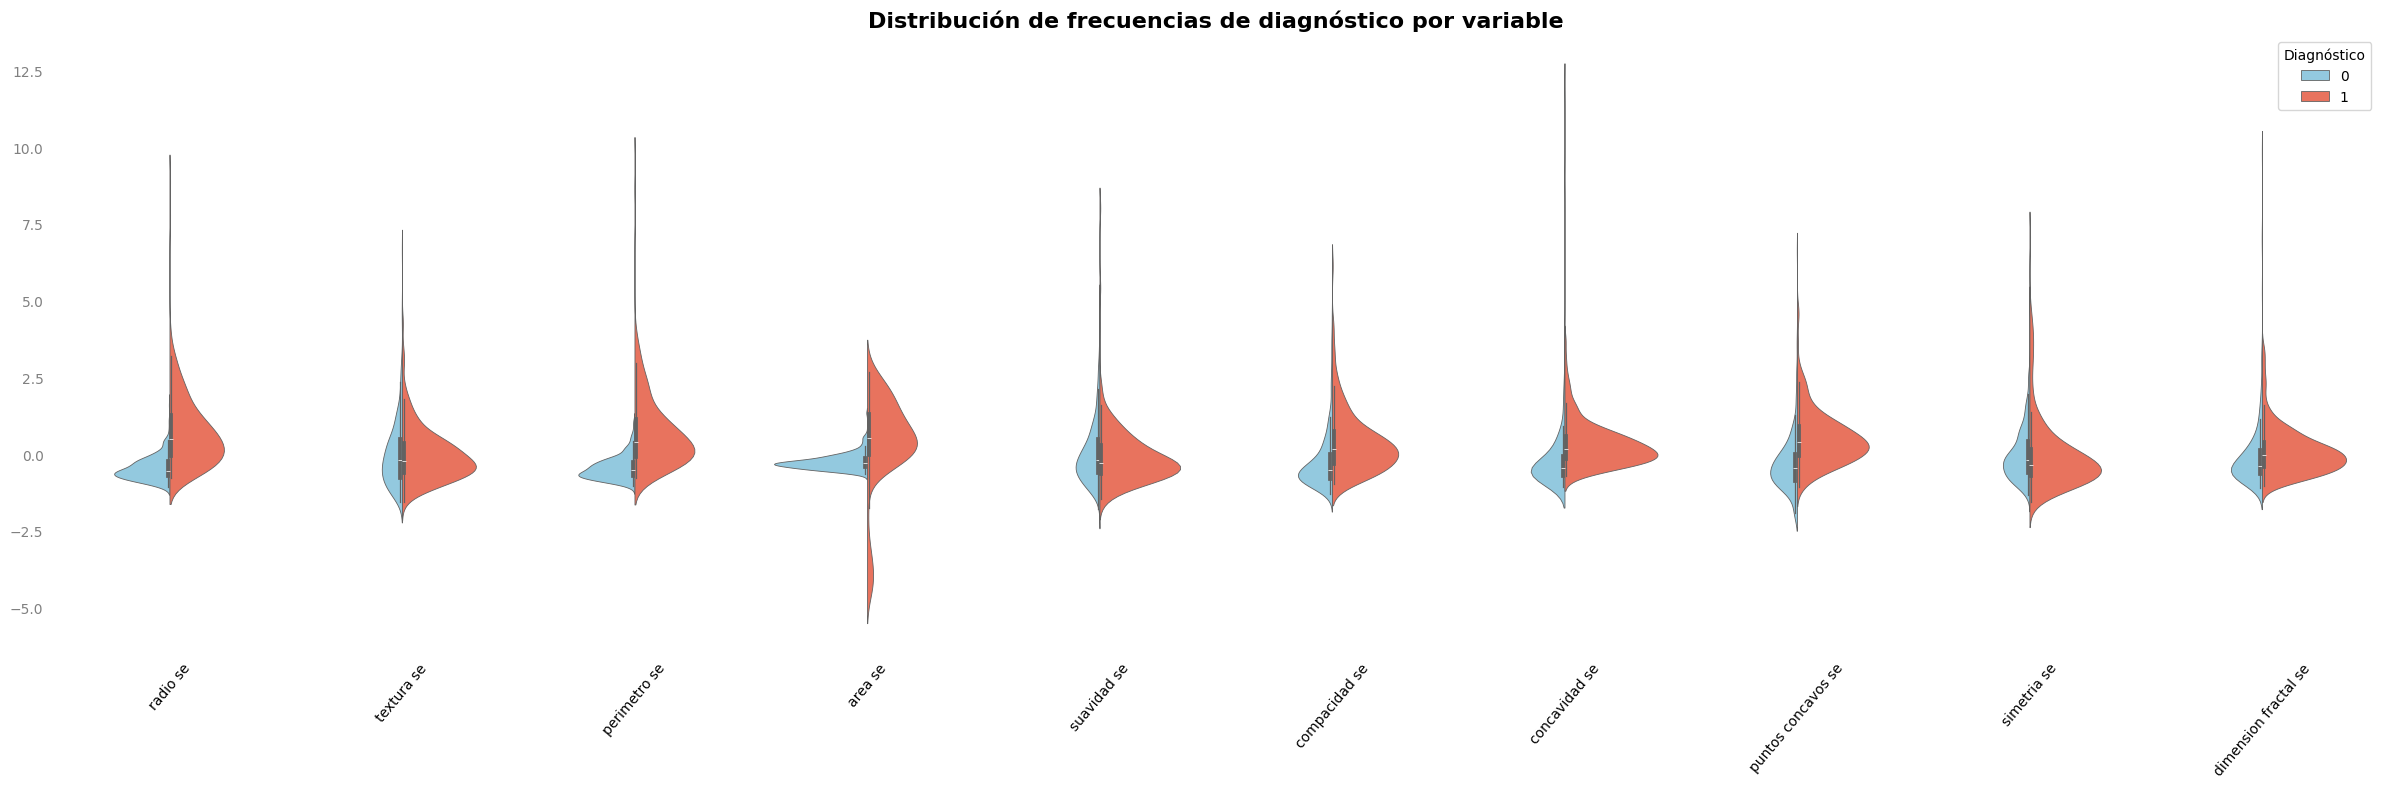

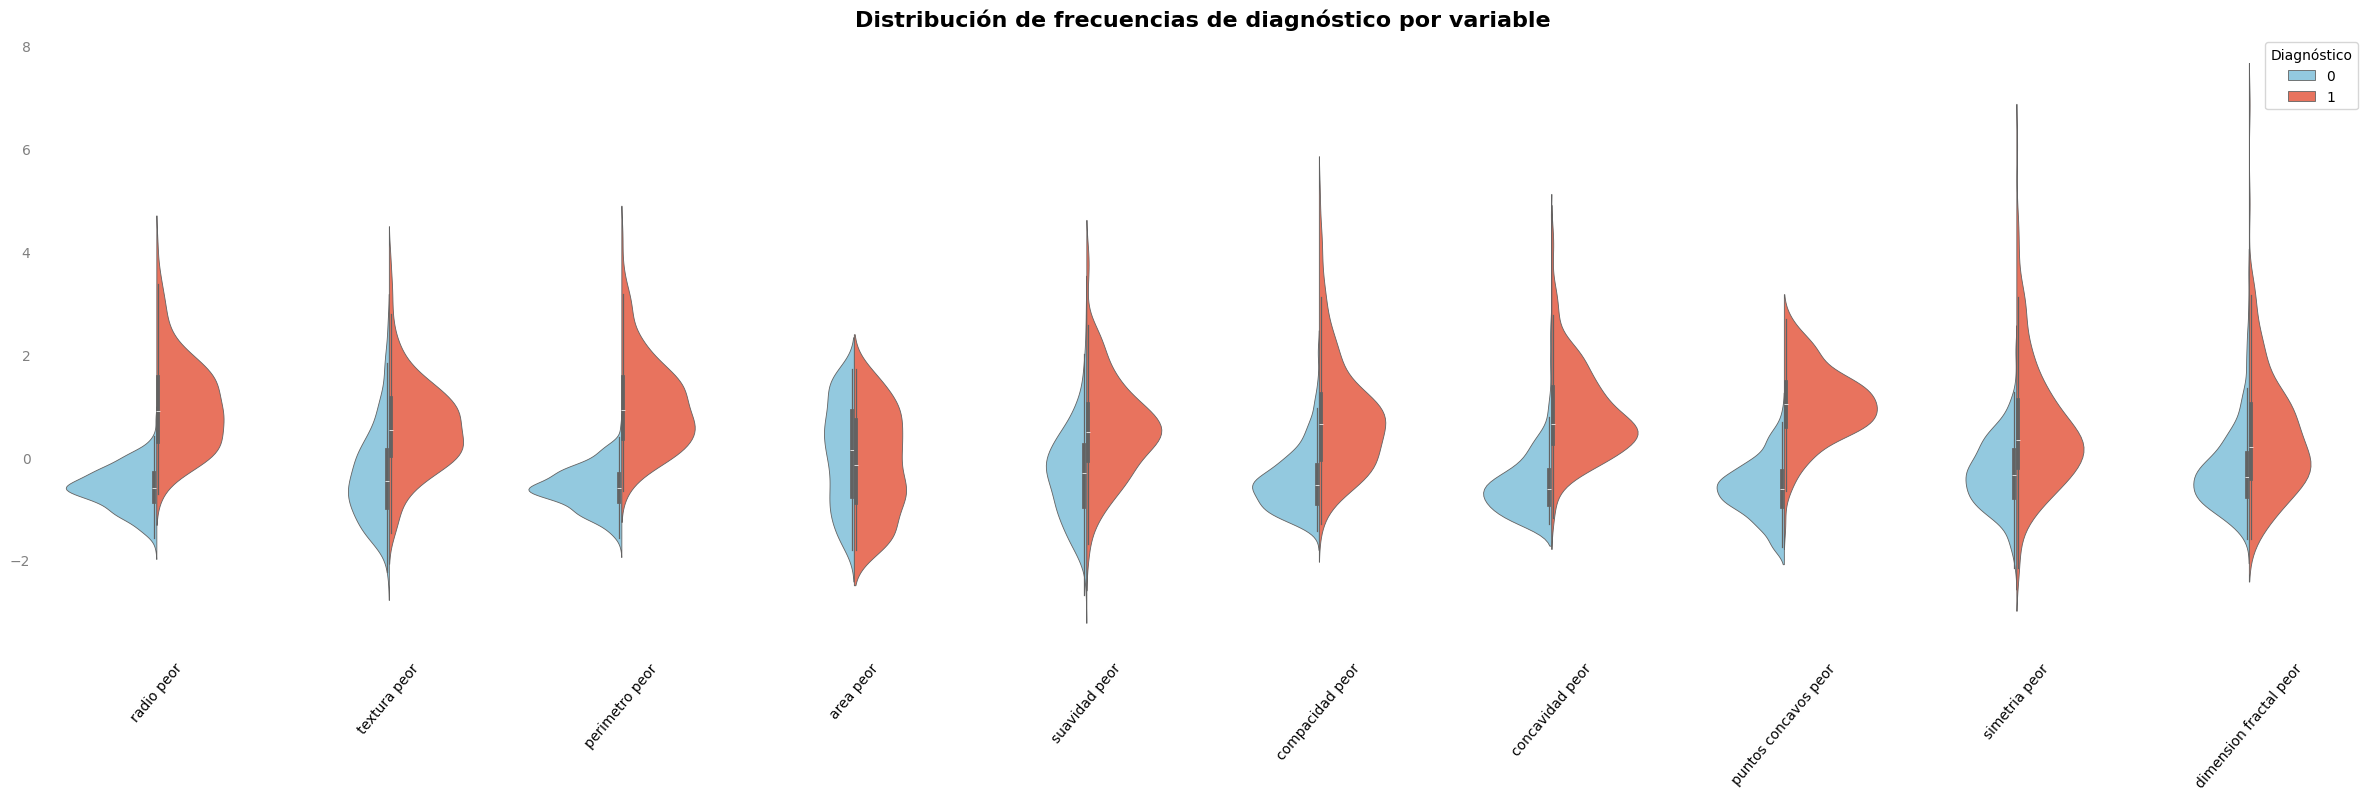

In [38]:
### gfraficar las 30 variables:
violin(0,10)
violin(10,20)
violin(20,30)

In [39]:
boxplot_var()

# 3. Datos correlacionados

In [40]:
X1.corr().head(5)

,radio promedio,textura promedio,perimetro promedio,area promedio,suavidad promedio,compacidad promedio,concavidad promedio,puntos concavos promedio,simetria promedio,dimension fractal promedio,radio se,textura se,perimetro se,area se,suavidad se,compacidad se,concavidad se,puntos concavos se,simetria se,dimension fractal se,radio peor,textura peor,perimetro peor,area peor,suavidad peor,compacidad peor,concavidad peor,puntos concavos peor,simetria peor,dimension fractal peor
radio promedio,1.000000,0.323721,0.997858,-0.016424,0.170600,0.506125,0.676786,0.822542,0.147583,-0.311638,0.679043,-0.097343,0.674152,0.218933,-0.222564,0.205975,0.194339,0.376201,-0.104312,-0.042631,0.969507,0.297017,0.965116,-0.096680,0.119571,0.413448,0.526842,0.744202,0.163929,0.007083
textura promedio,0.323721,1.000000,0.329516,-0.035336,-0.023395,0.236718,0.302402,0.293482,0.071349,-0.076325,0.275801,0.386431,0.281627,0.188991,0.006664,0.191957,0.143380,0.163849,0.009205,0.054565,0.352490,0.912063,0.357992,-0.037320,0.077494,0.277812,0.301029,0.295279,0.105101,0.119276
perimetro promedio,0.997858,0.329516,1.000000,-0.018024,0.207252,0.556939,0.716118,0.850992,0.182891,-0.261487,0.691735,-0.086717,0.693107,0.215868,-0.202639,0.250688,0.228143,0.407204,-0.081620,-0.005550,0.969487,0.303110,0.970402,-0.098740,0.150496,0.455792,0.563795,0.771242,0.189114,0.051060
area promedio,-0.016424,-0.035336,-0.018024,1.000000,-0.059653,-0.034654,-0.036704,-0.045535,-0.044933,0.008399,-0.081729,0.023786,-0.069415,0.019355,-0.044811,-0.029879,-0.013032,-0.054957,-0.033509,0.004231,-0.030743,-0.009579,-0.027787,-0.062466,-0.049280,-0.016979,-0.025237,-0.034872,-0.040368,0.005296
suavidad promedio,0.170600,-0.023395,0.207252,-0.059653,1.000000,0.659089,0.521944,0.553683,0.557773,0.584869,0.301382,0.068281,0.295995,0.042081,0.332197,0.318844,0.248394,0.380642,0.200610,0.283645,0.213137,0.036068,0.238822,-0.036136,0.805358,0.472447,0.434916,0.503070,0.394172,0.499309


<Axes: >

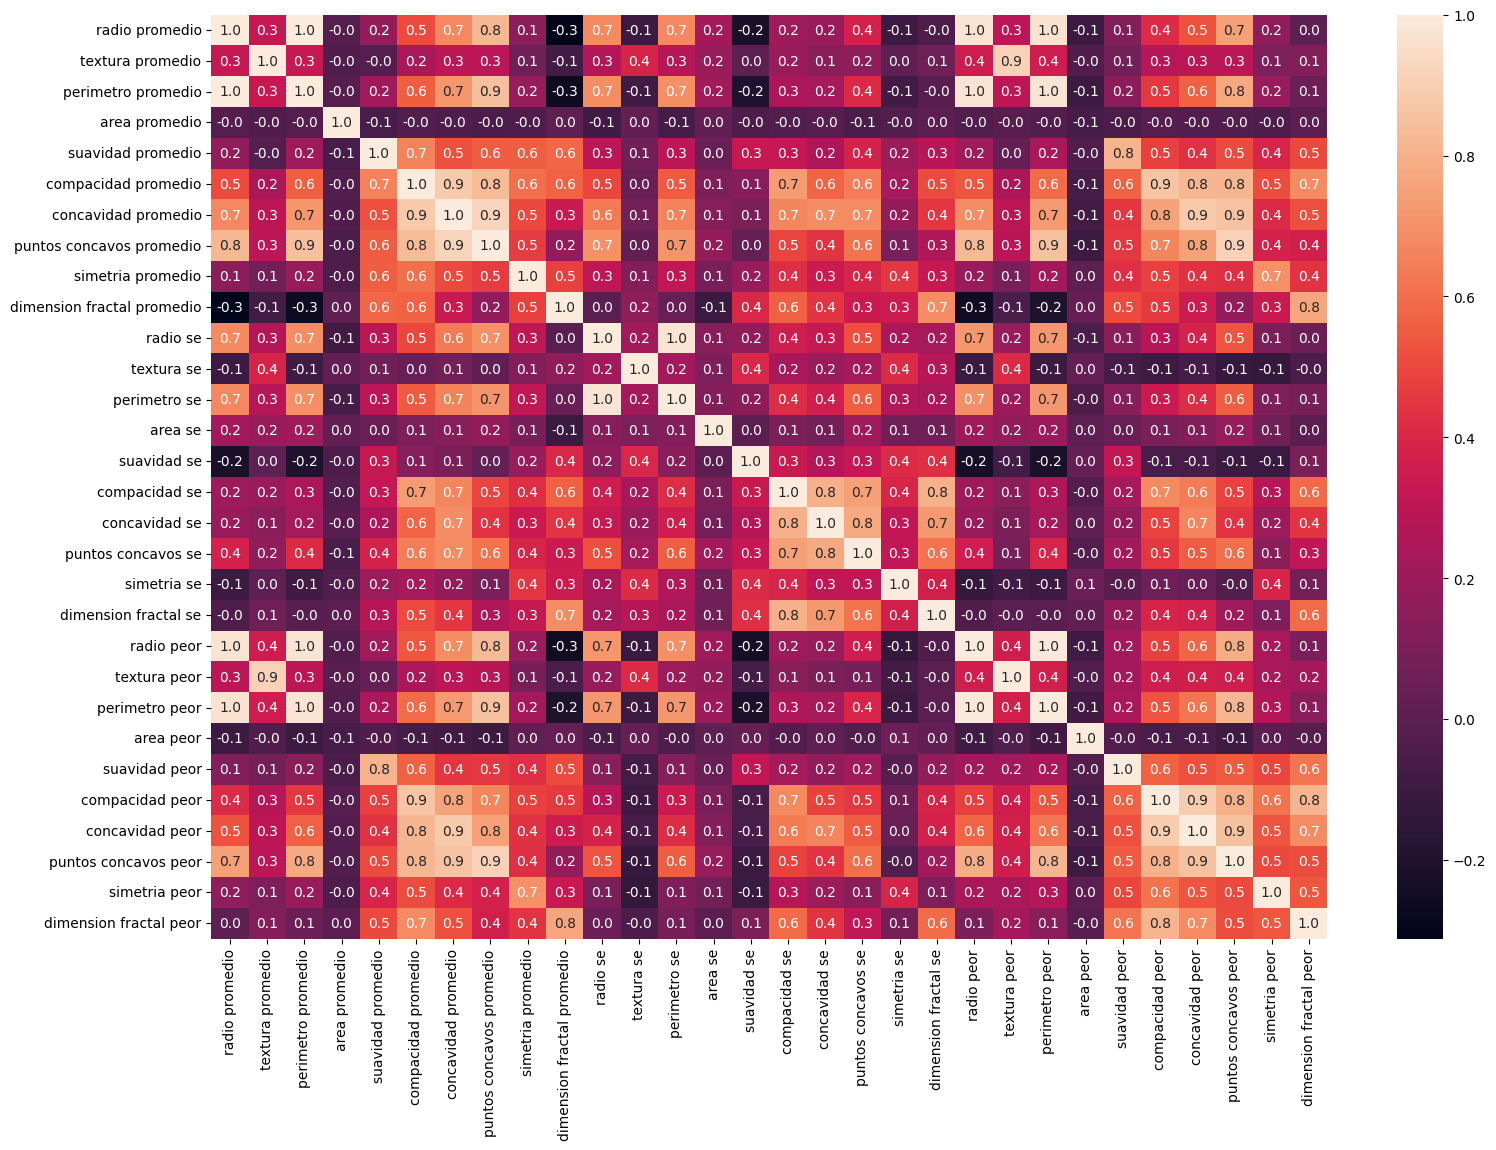

In [41]:
plt.figure(figsize=(18,12))
sns.heatmap(X1.corr(), annot=True, fmt='.1f')

In [42]:
correlation_matrix = X1.corr()

# Encontrar las características con correlación mayor a 0.99
high_correlation_features = set()  # Conjunto para almacenar las características con alta correlación

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.98:  # Verificar si la correlación es mayor a 0.99
            # Agregar las características a high_correlation_features
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            high_correlation_features.add(feature_i)
            high_correlation_features.add(feature_j)

# Imprimir las características con alta correlación
print("Características con correlación mayor a 0.98:")
# high_correlation_features_serie = pd.Series(high_correlation_features)

serie_high_correlation_features=[]
for i in high_correlation_features:
    serie_high_correlation_features.append(i)


serie_high_correlation_features

Características con correlación mayor a 0.98:


['radio peor', 'radio promedio', 'perimetro promedio', 'perimetro peor']

### Elimino de X1 las correlaciones de radio con: area y perimetro - creo X3

In [43]:
X3 = (X1.drop(columns=['perimetro promedio', 'perimetro peor','area peor','area promedio',], axis=1)).copy()
X3.head(1)

,radio promedio,textura promedio,suavidad promedio,compacidad promedio,concavidad promedio,puntos concavos promedio,simetria promedio,dimension fractal promedio,radio se,textura se,perimetro se,area se,suavidad se,compacidad se,concavidad se,puntos concavos se,simetria se,dimension fractal se,radio peor,textura peor,suavidad peor,compacidad peor,concavidad peor,puntos concavos peor,simetria peor,dimension fractal peor
0,1.095703,-2.072266,1.569336,3.283203,2.652344,2.53125,2.21875,2.257812,2.488281,-0.56543,2.830078,-3.740234,-0.2146,1.316406,0.724609,0.660645,1.148438,0.90625,1.886719,-1.360352,1.308594,2.617188,2.109375,2.294922,2.753906,1.936523


# 4. Graficas de puntos de variables numéricas en funcion de Diagnóstico

In [44]:
print(dataset.diagnostico.value_counts())


0    357
1    212
Name: diagnostico, dtype: int64


In [45]:
def pairplot_graf(var):
    columns_numeric = var
    df=dataset.copy()

    df.diagnostico.replace(1, 'Maligno', inplace=True)
    df.diagnostico.replace(0, 'Benigno', inplace=True)
    df_numeric = df[columns_numeric + ['diagnostico']]

    fig_size = (4, 4)
    sns.pairplot(df_numeric, hue='diagnostico', height=fig_size[1], aspect=fig_size[0]/fig_size[1],palette=['royalblue','red'])


    plt.subplots_adjust(top=0.95)
    plt.legend(df['diagnostico'].unique())
    plt.suptitle('Gráfico de dispersión ', fontsize=16)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(None)
    # print(df.diagnostico.value_counts())
    plt.show()
# pairplot_graf(['radio promedio'])

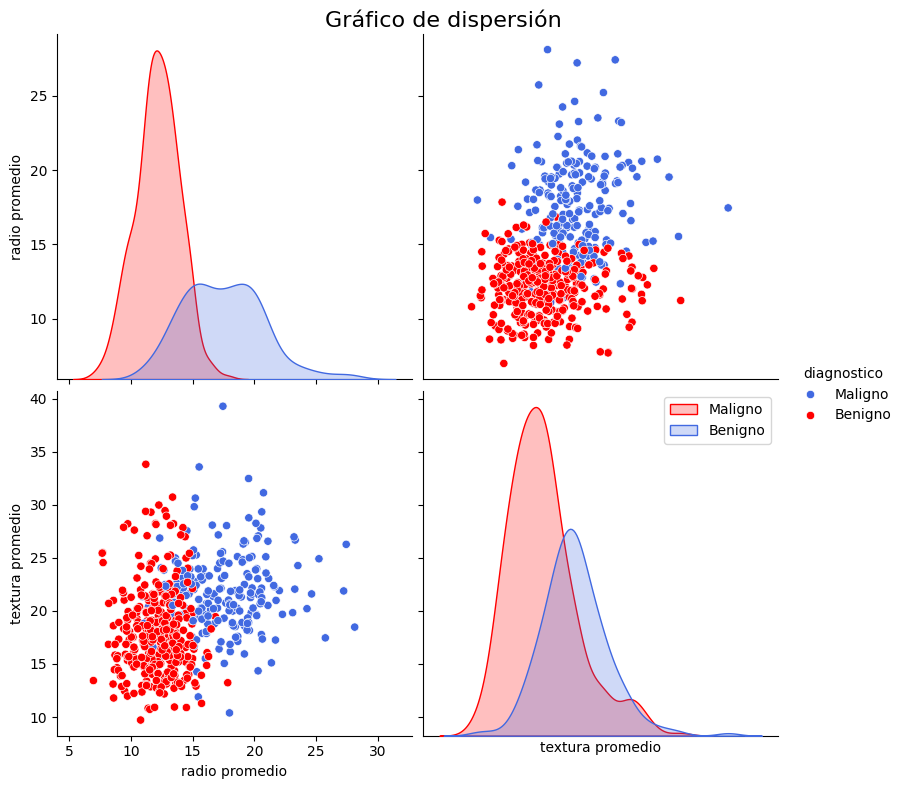

In [46]:
pairplot_graf(['radio promedio', 'textura promedio'])


# 5.1 Evalúo la Exactitud de X1, X3 con modelos LogistictRegression y MLPClassifier:

In [47]:
def puntaje00(X, y):
    var_name = [var_name for var_name, var in inspect.currentframe().f_back.f_locals.items() if var is X][0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size= 0.3)
    logistic = LogisticRegression(C=1, n_jobs=-1)
    logistic.fit(X_train, y_train)
    mlp = MLPClassifier(max_iter=200, solver='adam', learning_rate='adaptive', alpha=0.01)
    mlp.fit(X_train, y_train)

    # Almacenar los resultados en un diccionario
    results = {
        f'logistic': round(logistic.score(X_test, y_test) * 100, 4),
        f'mlp': round(mlp.score(X_test, y_test) * 100, 4)
    }

    # Convertir el diccionario en un DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=[f'Exact {var_name} {len(X.columns)}col'])

    return results_df

In [48]:
df1=puntaje00(X1, y)
df2=puntaje00(X3, y)
merged_df = pd.concat([df1, df2], axis=1)
merged_df

,Exact X1 30col,Exact X3 26col
logistic,98.2456,98.2456
mlp,98.2456,98.2456


# 5.2 Evalúo métricas modelos LogisticRegression y MLPClassifier:

## En LogisticRegression aplico RFECV (feature selection)
**for data of X1 and X3**

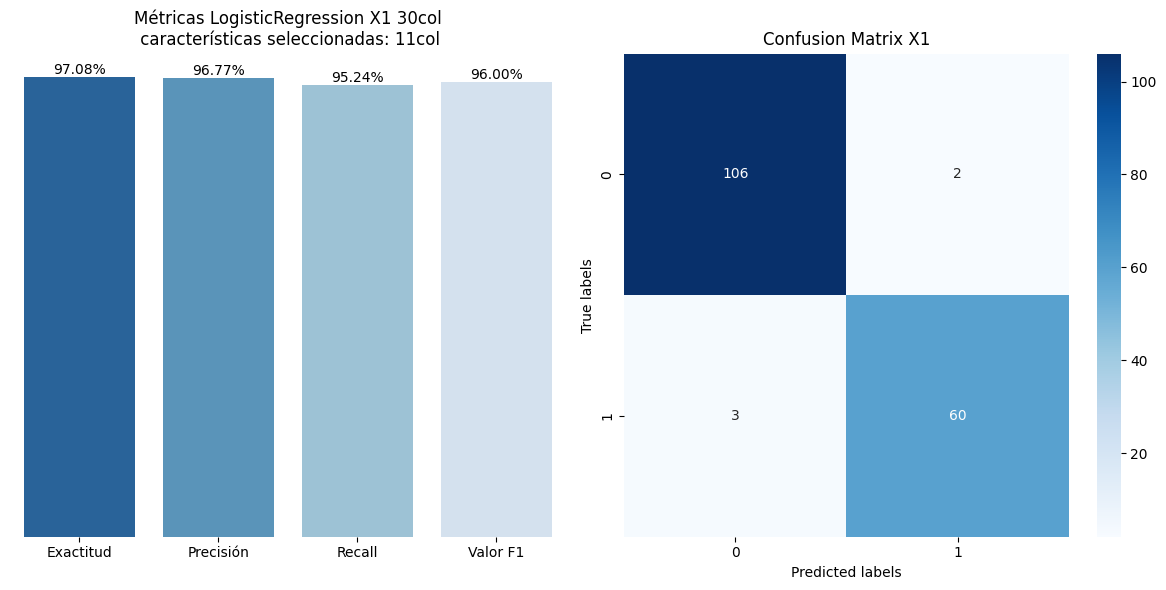

['compacidad promedio' 'concavidad promedio' 'puntos concavos promedio'
 'radio se' 'area se' 'dimension fractal se' 'radio peor' 'textura peor'
 'perimetro peor' 'concavidad peor' 'puntos concavos peor']


In [66]:
def puntaje_logistic(X):

    var_name = [var_name for var_name, var in inspect.currentframe().f_back.f_locals.items() if var is X][0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

    # Crear un selector de características RFECV con el clasificador de regresión logística
    logistic_regression = LogisticRegression(C=1, n_jobs=-1)
    rfecv_logistic = RFECV(estimator=logistic_regression, cv=5, scoring='accuracy')

    # Ajustar el selector de características al conjunto de entrenamiento
    rfecv_logistic.fit(X_train, y_train)

    # Transformar los conjuntos de entrenamiento y prueba
    rfecv_train = rfecv_logistic.transform(X_train)
    rfecv_test = rfecv_logistic.transform(X_test)


    # Crear un clasificador de regresión logística con características seleccionadas
    logistic_selected = LogisticRegression(C=1, n_jobs=-1)

    # Entrenar el clasificador con características seleccionadas
    logistic_selected.fit(rfecv_train, y_train)

    # Predicciones en el conjunto de prueba
    y_pred = logistic_selected.predict(rfecv_test)

    # Calcular métricas
    accuracy = logistic_selected.score(rfecv_test, y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Crear un DataFrame con las métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['Exactitud', 'Precisión', 'Recall', 'Valor F1'],
        'Puntuación': [accuracy, precision, recall, f1]
    })

    # Convertir las puntuaciones a porcentajes
    metrics_df['Puntuación'] *= 100

    # Crear la figura y los subgráficos
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Graficar el gráfico de barras en el primer subgráfico
    sns.barplot(x='Métrica', y='Puntuación', data=metrics_df, ax=axs[0], palette='Blues_r')
    # sns.barplot(x='Métrica', y='Puntuación', data=metrics_df, hue='Métrica', ax=axs[0], palette='viridis', legend=False)
    axs[0].set_title(f'Métricas LogisticRegression {var_name} {len(X1.columns)}col\n características seleccionadas: {rfecv_logistic.n_features_}col')
    axs[0].set_ylabel('Puntuación (%)')
    axs[0].set_yticks([])
    axs[0].set_xlabel('')
    axs[0].set_ylabel('')
    axs[0].grid(False)
    for spine in axs[0].spines.values():
        spine.set_visible(False)  # Ocultar los bordes

    # Agregar el valor de cada barra en el primer subgráfico
    for index, value in enumerate(metrics_df['Puntuación']):
        axs[0].text(index, value, f'{value:.2f}%', ha='center', va='bottom')

    # Suponiendo que conf_matrix es la matriz de confusión que deseas visualizar
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Visualizar la matriz de confusión como un mapa de calor en el segundo subgráfico
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted labels')
    axs[1].set_ylabel('True labels')
    axs[1].set_title(f'Confusion Matrix {var_name}')

    # Ajustar el diseño para evitar solapamiento
    plt.tight_layout()

    plt.show()
    selected_columns_rfecv = X_train.columns[rfecv_logistic.support_]
    # print('y_pred: ', y_pred)
    return selected_columns_rfecv

selected_columns_rfecv_X1 = puntaje_logistic(X1)
print(selected_columns_rfecv_X1.values)

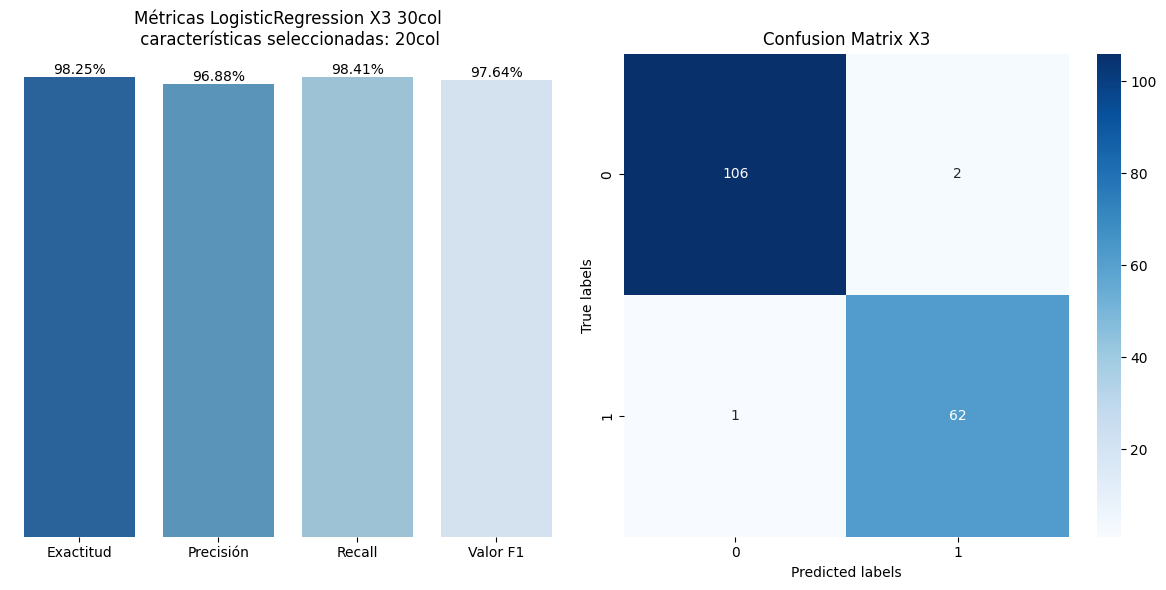

['radio promedio' 'textura promedio' 'compacidad promedio'
 'concavidad promedio' 'puntos concavos promedio' 'simetria promedio'
 'dimension fractal promedio' 'radio se' 'perimetro se' 'area se'
 'compacidad se' 'puntos concavos se' 'simetria se' 'dimension fractal se'
 'radio peor' 'textura peor' 'suavidad peor' 'concavidad peor'
 'puntos concavos peor' 'simetria peor']


In [67]:
selected_columns_rfecv_X3 = puntaje_logistic(X3)
print(selected_columns_rfecv_X3.values)

## En MLPClassifier
**for data of X1 and X3**

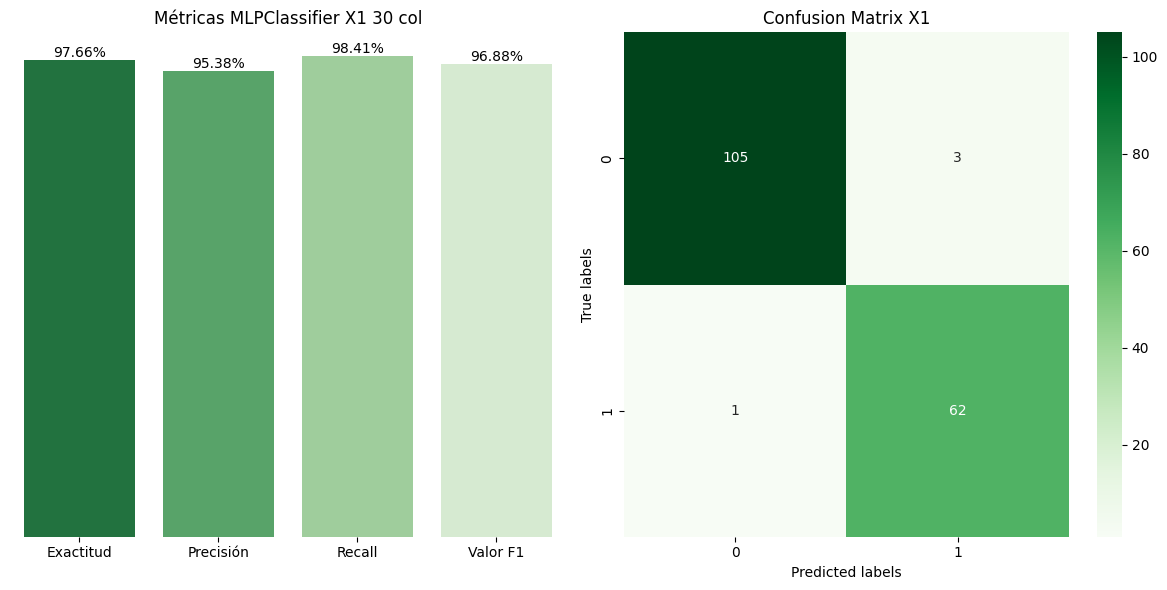

['radio promedio' 'textura promedio' 'perimetro promedio' 'area promedio'
 'suavidad promedio' 'compacidad promedio' 'concavidad promedio'
 'puntos concavos promedio' 'simetria promedio'
 'dimension fractal promedio' 'radio se' 'textura se' 'perimetro se'
 'area se' 'suavidad se' 'compacidad se' 'concavidad se'
 'puntos concavos se' 'simetria se' 'dimension fractal se' 'radio peor'
 'textura peor' 'perimetro peor' 'area peor' 'suavidad peor'
 'compacidad peor' 'concavidad peor' 'puntos concavos peor'
 'simetria peor' 'dimension fractal peor']


In [51]:
def graf_puntaje_mlp(X,y):
    # Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
    var_name = [var_name for var_name, var in inspect.currentframe().f_back.f_locals.items() if var is X][0]

    # Inicializar y ajustar el clasificador MLP
    mlp = MLPClassifier(max_iter=200, solver='adam', learning_rate='adaptive', alpha=0.01)
    mlp.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = mlp.predict(X_test)

    # Calcular las métricas
    accuracy = mlp.score(X_test, y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Crear un DataFrame con las métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['Exactitud', 'Precisión', 'Recall', 'Valor F1'],
        'Puntuación': [accuracy, precision, recall, f1]
    })

    # Convertir las puntuaciones a porcentajes
    metrics_df['Puntuación'] *= 100

    # Crear la figura y los subgráficos
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    sns.barplot(x='Métrica', y='Puntuación', data=metrics_df, ax=axs[0], palette='Greens_r')

    # Ajustar el ancho de las barras
    axs[0].set_xticklabels(metrics_df['Métrica'], rotation=0, ha='center')
    axs[0].set_title(f'Métricas MLPClassifier {var_name} {len(X_train.columns)} col')
    axs[0].set_ylabel('')
    axs[0].set_yticks([])
    axs[0].set_xlabel('')
    axs[0].grid(False)
    for spine in axs[0].spines.values():
        spine.set_visible(False)  # Ocultar los bordes

    # Agregar el valor de cada barra en el primer subgráfico
    for index, value in enumerate(metrics_df['Puntuación']):
        axs[0].text(index, value, f'{value:.2f}%', ha='center', va='bottom')
    axs[0].legend().remove()

    # Visualizar la matriz de confusión como un mapa de calor en el segundo subgráfico
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', ax=axs[1])
    axs[1].set_xlabel('Predicted labels')
    axs[1].set_ylabel('True labels')
    axs[1].set_title(f'Confusion Matrix {var_name}')

    # Ajustar el diseño para evitar solapamiento
    plt.tight_layout()
    plt.show()
    selected_columns = X_train.columns
    return selected_columns

selected_columns_mlp_X1 = graf_puntaje_mlp(X1,y)
print(selected_columns_mlp_X1.values)


## Traer las columnas seleccionadas por el metodo rfecv y aplicarlas con el modelo MLPClassifier

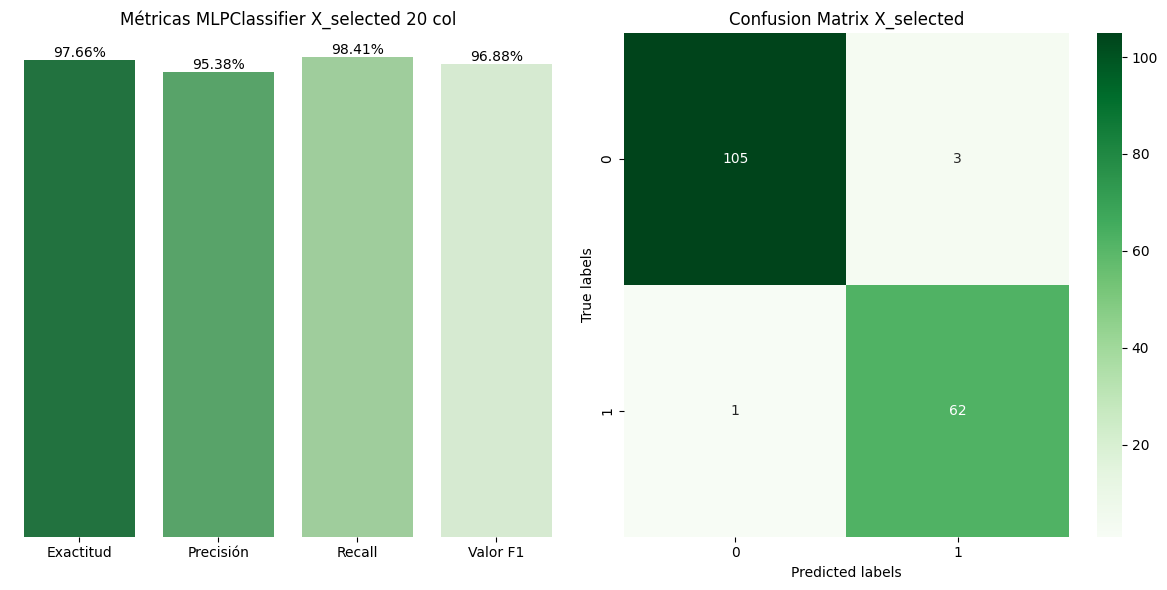

Index(['radio promedio', 'textura promedio', 'compacidad promedio',
       'concavidad promedio', 'puntos concavos promedio', 'simetria promedio',
       'dimension fractal promedio', 'radio se', 'perimetro se', 'area se',
       'compacidad se', 'puntos concavos se', 'simetria se',
       'dimension fractal se', 'radio peor', 'textura peor', 'suavidad peor',
       'concavidad peor', 'puntos concavos peor', 'simetria peor'],
      dtype='object')

In [52]:
X_selected = X1[selected_columns_rfecv_X3.values.tolist()]
graf_puntaje_mlp(X_selected,y)

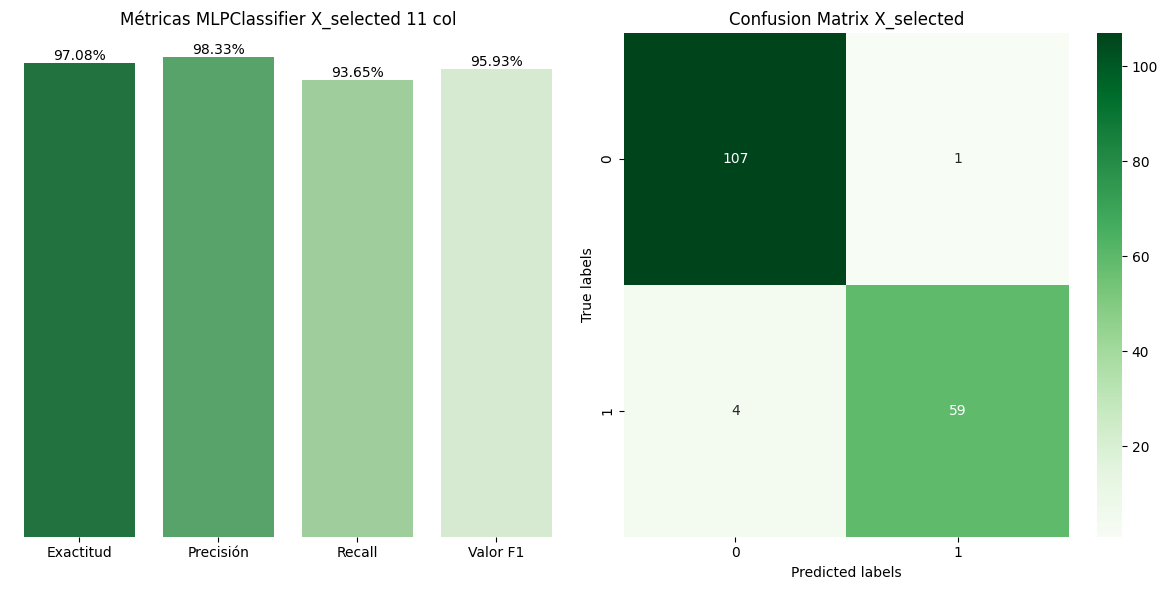

Index(['compacidad promedio', 'concavidad promedio',
       'puntos concavos promedio', 'radio se', 'area se',
       'dimension fractal se', 'radio peor', 'textura peor', 'perimetro peor',
       'concavidad peor', 'puntos concavos peor'],
      dtype='object')

In [53]:
X_selected = X1[selected_columns_rfecv_X1.values.tolist()]
graf_puntaje_mlp(X_selected,y)

# 6 Conclusion:
##Ambos modelor LR: LogisticRegressor como MLP: MLPClassifier tienen un recall de 98.41% lo que sugiere una excelente prediccion para evitar los falsos positivos, es decir tumores que son malignos son tomados como benigno. Pero el modelo de LR es estable, no así MLP.

# 7. Probando el modelo LR:

## Columnas selecionadas por RFECV:

In [87]:
dataset[selected_columns_rfecv_X1.values.tolist()].head(3)

,compacidad promedio,concavidad promedio,puntos concavos promedio,radio se,area se,dimension fractal se,radio peor,textura peor,perimetro peor,concavidad peor,puntos concavos peor
0,0.277588,0.300049,0.147095,1.094727,-103,0.006191,25.375000,17.328125,184.625,0.711914,0.265381
1,0.078613,0.086914,0.070190,0.543457,74,0.003532,24.984375,23.406250,158.750,0.241577,0.186035
2,0.159912,0.197388,0.127930,0.745605,94,0.004570,23.562500,25.531250,152.500,0.450439,0.243042


## Nuevo dataset con Max, Min, Mean

In [55]:
df=dataset[selected_columns_rfecv_X1.values.tolist()].copy()
maximos = df.max()
minimos = df.min()
medias = df.mean()
medianas = df.median()

print(df.isna().value_counts())
# Crea un nuevo DataFrame con estos valores y establece los nombres de las filas
for column in df.columns:
    if np.isinf(medias[column]):
        medias[column] = medianas[column]
df_max_min_mean = pd.DataFrame({'Max': maximos, 'Min': minimos, 'Mean': medias})

# # Establece los nombres de las filas como índices
# nuevo_df.index = ['Max', 'Min', 'Mean']
df_max_min_mean = reduce_memory_usage(df_max_min_mean, verbose=True)
df_max_min_mean.Mean.to_csv('/content/drive/MyDrive/Machine Learning alura/cancer/valores_max_min_mean.csv')
df_max_min_mean

compacidad promedio  concavidad promedio  puntos concavos promedio  radio se  area se  dimension fractal se  radio peor  textura peor  perimetro peor  concavidad peor  puntos concavos peor
False                False                False                     False     False    False                 False       False         False           False            False                   569
dtype: int64
Mem. usage decreased to 0.00 Mb (30.0% reduction)


,Max,Min,Mean
compacidad promedio,0.345459,0.019379,0.104370
concavidad promedio,0.426758,0.000000,0.088806
puntos concavos promedio,0.201172,0.000000,0.048920
radio se,2.873047,0.111511,0.405029
area se,124.000000,-128.000000,29.046875
dimension fractal se,0.029846,0.000895,0.003796
radio peor,36.031250,7.929688,16.265625
textura peor,49.531250,12.023438,25.671875
perimetro peor,251.250000,50.406250,107.250000
concavidad peor,1.251953,0.000000,0.272217


## Obtener datos para probar prediccion del modelo:

In [56]:
### Podemos tomar los valores Max, Min o Mean
df=dataset[selected_columns_rfecv_X1.values.tolist()].copy()
medias = df.mean()
medianas = df.median()

# Reemplazar los valores de la media con la mediana donde sea necesario
for column in df.columns:
    if np.isinf(medias[column]):
        medias[column] = medianas[column]

# Crear el DataFrame con los valores ajustados
df_mean = pd.DataFrame({'Mean': medias})
df_mean.Mean.values

array([1.04370117e-01, 8.88061523e-02, 4.89196777e-02, 4.05029297e-01,
       2.90509666e+01, 3.79562378e-03, 1.62656250e+01, 2.56718750e+01,
       1.07250000e+02, 2.72216797e-01, 1.14562988e-01])

## Crear linea de prueba para prediccón:

In [57]:
# Creando caso de prueba:
data = {
    'radio promedio': 12,
    'textura promedio': 39.28,
    'perimetro promedio': 188.5,
    'area promedio': 2501.0,
    'compacidad promedio': 0.3454,
    'concavidad promedio': 0.4268,
    'puntos concavos promedio': 0.2012,
    'simetria promedio': 0.304,
    'radio se': 2.873,
    'perimetro se': 21.98,
    'area se': 542.2,
    'suavidad se': 0.03113,
    'compacidad se': 0.1354,
    'puntos concavos se': 0.05279,
    'simetria se': 0.07895,
    'dimension fractal se': 0.02984,
    'radio peor': 36.04,
    'textura peor': 49.54,
    'perimetro peor': 251.2,
    'area peor': 4254.0,
    'suavidad peor': 0.2226,
    'concavidad peor': 1.252,
    'puntos concavos peor': 0.291,
    'simetria peor': 0.6638
}

# Crear el DataFrame a partir del diccionario, con el índice como una columna
df_test = pd.DataFrame(data.items(), columns=['Var', 'valor'])
df_test.head(3)


,Var,valor
0,radio promedio,12.00
1,textura promedio,39.28
2,perimetro promedio,188.50


In [78]:
X = dataset.drop(columns='diagnostico', axis=1)
y = dataset.diagnostico

scaler = StandardScaler()
scaler.fit(X)

X_std = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, random_state= 42, test_size= 0.3)

In [84]:
# DataFrame con los valores
df_max = df_max_min_mean.Max
df_min = df_max_min_mean.Min
df_mean = df_max_min_mean.Mean

# Seleccionar los valores de interés del DataFrame y convertirlos en un array
valores_max = df_max.values.flatten()
valores_min = df_min.values.flatten()
valores_mean = df_mean.values.flatten()
valores_test = df_test.valor.values.flatten()

# Crear y ajustar el StandardScaler, luego transformar los datos y aplanar el resultado
resultado_aplanado_max = scaler.fit_transform(valores_max.reshape(-1, 1)).ravel()
resultado_aplanado_min = scaler.fit_transform(valores_min.reshape(-1, 1)).ravel()
resultado_aplanado_mean = scaler.fit_transform(valores_mean.reshape(-1, 1)).ravel()
resultado_aplanado_test = scaler.fit_transform(valores_test.reshape(-1, 1)).ravel()

## 8. Predicción:

In [85]:
# Crear un selector de características RFECV con el clasificador de regresión logística
logistic_regression = LogisticRegression(C=1, n_jobs=-1)
rfecv_logistic = RFECV(estimator=logistic_regression, cv=5, scoring='accuracy')

rfecv_logistic.fit(X_train, y_train)

rfecv_train = rfecv_logistic.transform(X_train)
rfecv_test = rfecv_logistic.transform(X_test)

logistic_selected = LogisticRegression(C=1, n_jobs=-1)

# Entrenar el clasificador con características seleccionadas
logistic_selected.fit(rfecv_train, y_train)

y_pred_rfecv = logistic_selected.predict([rfecv_test[8]])
y_pred_max = logistic_selected.predict([resultado_aplanado_max])
y_pred_min = logistic_selected.predict([resultado_aplanado_min])
y_pred_mean = logistic_selected.predict([resultado_aplanado_mean])

print('Pronostico y_pred_rfecv: ', y_pred_rfecv[0])
print('Pronostico y_pred_max: ', y_pred_max[0])
print('Pronostico y_pred_min: ', y_pred_min[0])
print('Pronostico y_pred_mean: ', y_pred_mean[0])

Pronostico y_pred_rfecv:  0
Pronostico y_pred_max:  1
Pronostico y_pred_min:  0
Pronostico y_pred_mean:  1
